In [1]:
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxx--------------Plotting Simulated SLSN Light Curves-----------------xxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #

# ------------------------------------------------------------------------------------------------------------------- #
# Import Modules
# ------------------------------------------------------------------------------------------------------------------- #
import os
import random
import pickle
import sncosmo
import simsurvey
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

from RunSim_SLSN_Master import MagnetarSource, Load_ZTFData
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Initialize Globals
# ------------------------------------------------------------------------------------------------------------------- #
dict_bands = {'ztfg': [4087, 4722.7, 5522], 'ztfr': [5600, 6339.6, 7317], 'desi': [7317, 7886.1, 8884]}
dict_rlambda = {'ztfg': 3.694, 'ztfr': 2.425, 'desi': 1.718}
params_magnetar = ['P', 'B', 'Mej', 'Vej', 'kappa', 'kappa_gamma', 'Mns', 'Tf']

cm = cm.get_cmap('jet')

os.environ["HOME"] = "/data/asingh/simsurvey"
DIR_HOME = os.environ.get("HOME")
DIR_INPUT = os.path.join(DIR_HOME, "data/")
DIR_PLOTS = os.path.join(DIR_HOME, "plots/")

# Name of the File containing the parameters for the Magnetar Model
file_param = os.path.join(DIR_INPUT, "Nicholl_Magnetar.dat")
file_paramflat = os.path.join(DIR_INPUT, "Nicholl_Magnetar_Flat.dat")

# Name of the File containing the Template Light Curve
file_template = os.path.join(DIR_INPUT, "PTF12dam.dat")

# Name of the File containing the probabilities of drawing a Magnetar Model
file_pdf = os.path.join(DIR_INPUT, "LFV2.dat")

# Name of the File containing the ZTF Observed Sample
file_sample = os.path.join(DIR_INPUT, "ZTFSampleV2.csv")

# Location of the Output Directory where the Pickle files are saved
DIR_OUTPUT = os.path.join(DIR_HOME, "output/Run_Apr2_RateLFV2")
# ------------------------------------------------------------------------------------------------------------------- #
# Location of the Plots Directory where the plots will be saved
DIR_PLOTS = os.path.join(DIR_HOME, "plots/")

if not os.path.exists(DIR_PLOTS):
    print("Plots Directory Doesn't Exist. Creating one...")
    os.makedirs(DIR_PLOTS)

os.chdir(DIR_PLOTS)
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Specify Pickle File To Read
# ------------------------------------------------------------------------------------------------------------------- #
prefix = 'LCS_Filtered_SLSN'
runmodel = 'Magnetar'
zrange = (0.07, 0.40)
rate = 1.00
iteration = 0

filename = "{0}_{1}_{2:.2f}_{3:.2f}_{4:.2f}_{5}.pkl".format(prefix, runmodel, zrange[0], zrange[1], rate, iteration)
print (filename)

data_mod = pickle.load(open(os.path.join(DIR_OUTPUT, filename), 'rb'))
lcs = simsurvey.LightcurveCollection(load=os.path.join(DIR_OUTPUT, filename))
print ("Number of Light Curves in Filtered Data: {0}".format(len(lcs.lcs)))
# ------------------------------------------------------------------------------------------------------------------- #


LCS_Filtered_SLSN_Magnetar_0.07_0.40_1.00_0.pkl
Number of Light Curves in Filtered Data: 305


### Helper Functions

In [2]:
# ------------------------------------------------------------------------------------------------------------------- #

def z_to_distmod(z):
    distance = Planck15.luminosity_distance(z).value
    return 5 * np.log10(distance * 1e6) - 5


def display_text(text_to_display):
    """
    Displays text mentioned in the string 'text_to_display'
    Args:
        text_to_display : Text to be displayed
    Returns:
        None
    """
    print("# " + "-" * (12 + len(text_to_display)) + " #")
    print("# " + "-" * 5 + " " + str(text_to_display) + " " + "-" * 5 + " #")
    print("# " + "-" * (12 + len(text_to_display)) + " #\n")

# ------------------------------------------------------------------------------------------------------------------- #

### Needed for Plotting Magnetar Models
1) Initialize Magnetar Model with Propagation Effects <br />
2) Load ZTF Filters <br />
3) Read the Sample of Magnetar Parameters from Nicholl et al. 2017 <br />

In [3]:
# ------------------------------------------------------------------------------------------------------------------- #
source = MagnetarSource()
dust = sncosmo.CCM89Dust()
pdf_df = pd.read_csv(file_pdf, sep='\s+')
mag_arr = pdf_df['mag'].values

bands = {'ztfg': 'ztfg_eff.txt', 'ztfr': 'ztfr_eff.txt', 'ztfi': 'ztfi_eff.txt'}

for band in bands.keys():                                                                             
    bpass = np.loadtxt(os.path.join(DIR_INPUT, bands[band]))                                         
    bandname = sncosmo.Bandpass(bpass[:, 0], bpass[:, 1], name=band)                                   
    sncosmo.registry.register(bandname, force=True)

try:
    prop_df = pd.read_csv(file_param, sep='\s+', comment='#')
    propflat_df = pd.read_csv(file_paramflat, sep='\s+', comment='#')
except OSError or FileNotFoundError:
    display_text("ERROR: File with Magnetar Parameters Missing. Using default parameters instead...")
    SLSN_prop = {'P': [4.78, 2.93, 2.28, 0.98, 3.5],
                 'B': [2.03e14, 1.23e14, 1.8e13, 0.49e14, 1.56e14],
                 'Mej': [2.19, 4.54, 6.27, 33.71, 2.75],
                 'Vej': [5.12, 9.02, 7.01, 8.71, 8.38],
                 'kappa': [0.1, 0.16, 0.16, 0.19, 0.12],
                 'kappa_gamma': [0.06, 0.57, 0.01, 0.01, 0.04],
                 'Mns': [1.85, 1.83, 1.83, 1.8, 1.8],
                 'Tf': [6.58e3, 8e3, 6.48e3, 6.78e3, 5.07e3]}
else:
#     prop_df = prop_df.loc[prop_df['z'] <= 0.4]
    SLSN_prop = {}
    SLSN_prob = {}
    SLSN_probflat = {}

    for idx in range(prop_df.shape[0]):
        mag = mag_arr[np.abs(mag_arr - prop_df.loc[idx, 'M_g']).argmin()]
        SLSN_prob[idx] = pdf_df.loc[pdf_df['mag'] == mag, 'prob'].values[0]
    for idx in range(propflat_df.shape[0]):
        mag = mag_arr[np.abs(mag_arr - propflat_df.loc[idx, 'M_g']).argmin()]
        SLSN_probflat[idx] = pdf_df.loc[pdf_df['mag'] == mag, 'prob'].values[0]

    for name in params_magnetar:
        if name == 'B':
            SLSN_prop[name] = 1e14 * prop_df[name].values
        elif name == 'Tf':
            SLSN_prop[name] = 1e3 * prop_df[name].values
        else:
            SLSN_prop[name] = prop_df[name].values

# ------------------------------------------------------------------------------------------------------------------- #


### Plotting Functions

In [4]:
# ------------------------------------------------------------------------------------------------------------------- #

def set_plotparams(ax_obj, xticks=(100, 10), yticks=(1, 0.1), fs=14, grid=True, color='k'):
    """
    Sets plot parameters for plotting Simulated Light Curves.
    """
    if grid:
        ax_obj.grid(True, which='major', ls='--', lw=1)
    ax_obj.xaxis.set_ticks_position('both')
    ax_obj.yaxis.set_ticks_position('both')
    ax_obj.xaxis.set_major_locator(MultipleLocator(xticks[0]))
    ax_obj.xaxis.set_minor_locator(MultipleLocator(xticks[1]))
    ax_obj.yaxis.set_major_locator(MultipleLocator(yticks[0]))
    ax_obj.yaxis.set_minor_locator(MultipleLocator(yticks[1]))
    ax_obj.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, color=color, 
                       labelcolor=color, labelsize=fs)
    ax_obj.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, color=color, 
                       labelcolor=color, labelsize=fs)

    
def set_plotsingle(lc, band, ax_obj1, ax_obj2, data=data_mod):
    """
    Sets plot parameters for plotting individual Simulated Light Curve.
    """
    appmin = df['mag'].max()
    appmax = df['mag'].min()
    absmin = df['absmag'].max()
    absmax = df['absmag'].min()

    ax_obj1.set_ylim(appmin + 0.5, appmax - 0.5)
    ax_obj2.set_ylim(absmin + 0.5, absmax - 0.5)
    
    ep_det = data['stats']['p_det'][lc]
    ep_last = data['stats']['p_last'][lc]
    mag_max = data['stats']['mag_max'][band][lc]

    ax_obj1.axvline(0, ls='-', lw=2, color='k')
    ax_obj2.axvline(0, ls='-', lw=2, color='k')
    ax_obj1.axvline(ep_det, ls='-', lw=2, color='orangered')
    ax_obj2.axvline(ep_det, ls='-', lw=2, color='orangered')
    ax_obj1.axvline(ep_last, ls='-', lw=2, color='orangered')
    ax_obj2.axvline(ep_last, ls='-', lw=2, color='orangered')
    ax_obj1.axhline(appmax, ls='-', lw=2, color='k')
    ax_obj2.axhline(absmax, ls='-', lw=2, color='k')
    
    ax_obj1.text(ep_det - 11, appmax + 0.5, 'Detection Epoch', fontsize=10, rotation=90)
    ax_obj2.text(ep_det - 11, absmax + 0.5, 'Detection Epoch', fontsize=10, rotation=90)
    ax_obj1.text(ep_last - 11, appmax + 0.5, 'Last Epoch', fontsize=10, rotation=90)
    ax_obj2.text(ep_last - 11, absmax + 0.5, 'Last Epoch', fontsize=10, rotation=90)
    ax_obj1.text(100, appmax - 0.05, 'Maximum Magnitude', fontsize=10)
    ax_obj2.text(100, absmax - 0.05, 'Maximum Magnitude', fontsize=10)

    if runmodel == 'Magnetar':
        ax_obj1.text(-11, appmax + 0.5, 'Explosion Epoch', fontsize=10, rotation=90)
        ax_obj2.text(-11, absmax + 0.5, 'Explosion Epoch', fontsize=10, rotation=90)
    elif runmodel == 'Template':
        ax_obj1.text(-11, appmax + 0.5, 'Maximum Epoch', fontsize=10, rotation=90)
        ax_obj2.text(-11, absmax + 0.5, 'Maximum Epoch', fontsize=10, rotation=90)
    else:
        pass


def plot_lcs(ax, df, lc, band, alpha=0.5, xlim=(-20, 370), data=data_mod, single=False):
    """
    Plots the Simulated Light Curves in a 2 x 3 Grid with 2 rows depicting the Apparent 
    and the Absolute Light Curves, respectively whereas the 3 columns depict the different 
    ZTF filters.
    """
    if band == 'ztfg':
        index = 0
        color = 'g'
    elif band == 'ztfr':
        index = 1
        color = 'r'
    elif band == 'desi':
        index =  2
        color = 'blue'

    ax_obj1 = ax[0][index]
    ax_obj2 = ax[1][index]

    ax_obj1.errorbar(df['phase'], df['mag'], yerr=df['magerr'], ms=8, alpha=alpha, ls='-',
                    color='dimgrey', markerfacecolor=color, markeredgewidth=0.5, marker='o', 
                     capthick=1, elinewidth=1, capsize=2, zorder=1, label='_nolegend_')
    ax_obj2.errorbar(df['restphase'], df['absmag'], yerr=df['magerr'], ms=8, alpha=alpha, ls='', 
                     color='dimgrey', marker='o', markerfacecolor=color, markeredgewidth=0.5, 
                     capthick=1, elinewidth=1, capsize=2, zorder=1, label='_nolegend_')

    if single:
        set_plotsingle(lc, band, ax_obj1, ax_obj2, data=data)
    else:
        ax_obj1.set_ylim(22.4, 14.6)
        ax_obj2.set_ylim(-15.8, -23.8)

    set_plotparams(ax_obj1)
    set_plotparams(ax_obj2)
    ax_obj1.set_xlim(xlim[0], xlim[1])
    ax_obj1.set_title(band, color=color, fontsize=16)
    ax_obj2.set_xlabel('Phase [In Days]', fontsize=16)    
    
    
def read_lc(lc):
    global data_mod, lcs
    lc_df = pd.DataFrame(data=data_mod['lcs'][lc], columns=data_mod['lcs'][lc].dtype.names)
    lc_df['mag'] = -2.5 * np.log10(lc_df['flux']) + lc_df['zp']
    lc_df['magerr'] = -(2.5 / np.log(10)) * (lc_df['fluxerr'] / lc_df['flux'])
    lc_df['snr'] = lc_df['flux'] / lc_df['fluxerr']
    lc_df['phase'] = lc_df['time'] - data_mod['meta']['t0'][lc]
    lc_df['Alambda'] = lc_df['band'].apply(lambda band: data_mod['meta']['mwebv_sfd98'][lc] * dict_rlambda[band])

    zlc = data_mod['meta']['z'][lc]
    distmag = 5 * np.log10(Planck15.luminosity_distance(zlc).value * 1e6) - 5
    corr = distmag - 2.5 * np.log10((1 + zlc))
    
    lc_df['restphase'] = lc_df['phase'] / (1 + zlc)
    lc_df['absmag'] = lc_df['mag'] - corr - lc_df['Alambda']
    lc_df = lc_df[lc_df['snr'] >= 3]

    for band, band_df in lc_df.groupby('band'):
        data_mod['stats']['mag_max'][band][lc] = band_df['mag'].min()
        lcs.stats['mag_max'][band][lc] = band_df['mag'].min()
        lcs.stats['absmag_max'][band][lc] = band_df['mag'].min() - corr

    return lc_df

# ------------------------------------------------------------------------------------------------------------------- #


### PLOT - Distribution of Peak 'ztfg' Absolute Magnitudes of the Input

In [38]:
# # ------------------------------------------------------------------------------------------------------------------- #
# fig0, (ax01, ax02) = plt.subplots(2, 1, sharex=True, figsize=(9, 15))

# ztf_df = pd.read_csv(file_sample, comment='#'); print (ztf_df.shape[0])
# ztfsample = list(ztf_df['gpeak_abs'].values)

# h_absmg, b_absmg = np.histogram(dict_peakabsmag['ztfg'], range=(-23.5, -19.5), bins=8)
# c_absmg = (b_absmg[:-1] + b_absmg[1:]) / 2

# ax01.bar(c_absmg, h_absmg, width=0.5, color='green', ec='k', lw=3, alpha=0.5, label='Nicholl et al. (2017)')
# ax02.hist(ztfsample, bins=7, color='orange', ec='k', density=True, alpha=0.5, lw=2, label='ZTF Sample')
# ax02.hist(itersampleflat, bins=7, color='dodgerblue', ec='k', alpha=0.5, histtype='bar', lw=2, density=True,
#           hatch='/',label='Input')

# ax01.set_xlim(-23.3, -19.0)
# ax01.legend(fontsize=15)
# ax02.legend(fontsize=15)
# set_plotparams(ax01, xticks=(0.5, 0.1), yticks=(4, 1), fs=14, grid=False)
# set_plotparams(ax02, xticks=(0.5, 0.1), yticks=(0.2, 0.02), fs=14, grid=False)
# ax02.set_xlabel("'ztfg' - Peak Absolute Magnitude [mag]", color='g', fontsize=16)
# ax01.set_ylabel('Normalized Fraction of SNe', fontsize=16)
# ax02.set_ylabel('Normalized Fraction of SNe', fontsize=16)
# ax01.set_title('Input Peak Absolute Magnitude Distribution [N = {0}]'.format(iterations), fontsize=16)

# fig0.subplots_adjust(hspace=0.03)
# fig0.savefig('PLOT_InputSelectionDistribution.pdf', format='pdf', dpi=2000, bbox_inches='tight')
# plt.show()
# plt.close(fig0)
# # ------------------------------------------------------------------------------------------------------------------- #


In [56]:
idxdata = pd.read_csv(os.path.join(DIR_HOME, 'notebooks/LogSim_Indexes.dat'), sep='\s+', names=['run', 'idx'])
idxdata = idxdata.set_index('run')
print (idxdata.sort_values(by='idx'))
for val, val_df in idxdata.groupby(by='idx'):
    print (val, val_df.shape[0])

      idx
run      
503     0
2559    0
916     0
2555    0
1748    0
...   ...
2197   17
2424   17
500    17
2098   17
1014   17

[3481 rows x 1 columns]
0 135
1 293
2 213
3 328
4 159
5 238
6 300
7 261
8 295
9 213
10 240
11 34
12 187
13 237
14 276
15 22
16 40
17 10


Size of ZTF Sample = 69


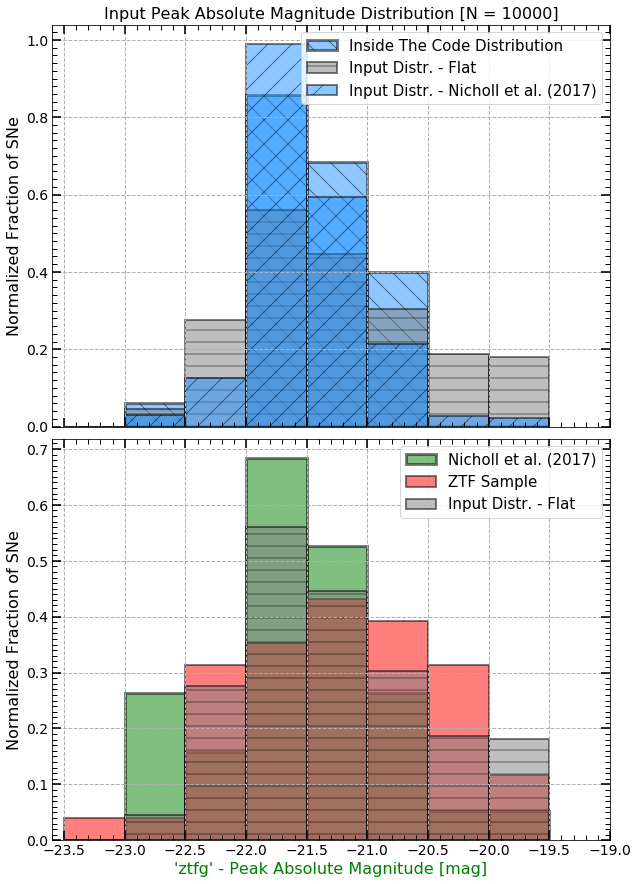

In [51]:
# ------------------------------------------------------------------------------------------------------------------- #
fig0, (ax01, ax02) = plt.subplots(2, 1, sharex=True, figsize=(10, 15))

ztf_df = pd.read_csv(file_sample, comment='#'); print ("Size of ZTF Sample = {0}".format(ztf_df.shape[0]))
ztf_df = ztf_df[ztf_df['redshift'] <= 0.4]
ztf_df = ztf_df[(ztf_df['gpeak'] <= 19.5) | (ztf_df['rpeak'] <= 19.5)]

idxdata = pd.read_csv(os.path.join(DIR_HOME, 'notebooks/LogSim_Indexes.dat'), sep='\s+', names=['run', 'idx'])
idxdata = idxdata.set_index('run')
idxsampleflat = [propflat_df.loc[i, 'M_g'] for i in idxdata['idx'].values]

ztfsample = list(ztf_df['gpeak_abs'].values)
ztfappg = list(ztf_df['gpeak'].values)
ztfappr = list(ztf_df['rpeak'].values)
ztfz = list(ztf_df['redshift'].values)

iterations = 10000
idx = random.choices(population=list(SLSN_prob.keys()), weights=list(SLSN_prob.values()), k=iterations)
idxflat = random.choices(population=list(SLSN_probflat.keys()), weights=list(SLSN_probflat.values()), k=iterations) 
itersample = [prop_df.loc[i, 'M_g'] for i in idx]
itersampleflat = [propflat_df.loc[i, 'M_g'] for i in idxflat]

h_absmg, b_absmg = np.histogram(prop_df['M_g'], range=(-23.5, -19.5), normed=True, bins=8)
h_ztf, b_ztf = np.histogram(ztfsample, range=(-23.5, -19.5), normed=True, bins=8)
h_iter, b_iter = np.histogram(itersample, range=(-23.5, -19.5), normed=True, bins=8)
h_iterf, b_iterf = np.histogram(itersampleflat, range=(-23.5, -19.5), normed=True, bins=8)
c_absmg = (b_absmg[:-1] + b_absmg[1:]) / 2
c_ztf = (b_ztf[:-1] + b_ztf[1:]) / 2
c_iter = (b_iter[:-1] + b_iter[1:]) / 2
c_iterf = (b_iterf[:-1] + b_iterf[1:]) / 2

h_idx, b_idx = np.histogram(idxsampleflat, range=(-23.5, -19.5), normed=True, bins=8)
c_idx = (b_idx[:-1] + b_idx[1:]) / 2


ax01.bar(c_idx, h_idx, width=0.5, color='dodgerblue', ec='k', lw=3, alpha=0.5,
         hatch='\ ', label='Inside The Code Distribution')
ax02.bar(c_absmg, h_absmg, width=0.5, color='green', ec='k', lw=3, alpha=0.5,
         label='Nicholl et al. (2017)')
ax01.bar(c_iterf, h_iterf, width=0.5, color='grey', ec='k', alpha=0.5, lw=2,
         hatch='-',label='Input Distr. - Flat')
ax01.bar(c_iter, h_iter, width=0.5, color='dodgerblue', ec='k', alpha=0.5, lw=2,
         hatch='/',label='Input Distr. - Nicholl et al. (2017)')
ax02.bar(c_ztf, h_ztf, width=0.5, color='red', ec='k', alpha=0.5, lw=2, label='ZTF Sample')
ax02.bar(c_iterf, h_iterf, width=0.5, color='grey', ec='k', alpha=0.5, lw=2,
         hatch='-',label='Input Distr. - Flat')

ax01.set_xlim(-23.6, -19.0)
ax01.legend(fontsize=15)
ax02.legend(fontsize=15)
set_plotparams(ax01, xticks=(0.5, 0.1), yticks=(0.2, 0.02), fs=14, grid=True)
set_plotparams(ax02, xticks=(0.5, 0.1), yticks=(0.1, 0.01), fs=14, grid=True)
ax02.set_xlabel("'ztfg' - Peak Absolute Magnitude [mag]", color='g', fontsize=16)
ax01.set_ylabel('Normalized Fraction of SNe', fontsize=16)
ax02.set_ylabel('Normalized Fraction of SNe', fontsize=16)
ax01.set_title('Input Peak Absolute Magnitude Distribution [N = {0}]'.format(iterations), fontsize=16)

fig0.subplots_adjust(hspace=0.03)
fig0.savefig('PLOT_InputSelectionDistributionV2.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig0)
# ------------------------------------------------------------------------------------------------------------------- #


### PLOT - Summation of Simulated Light Curves

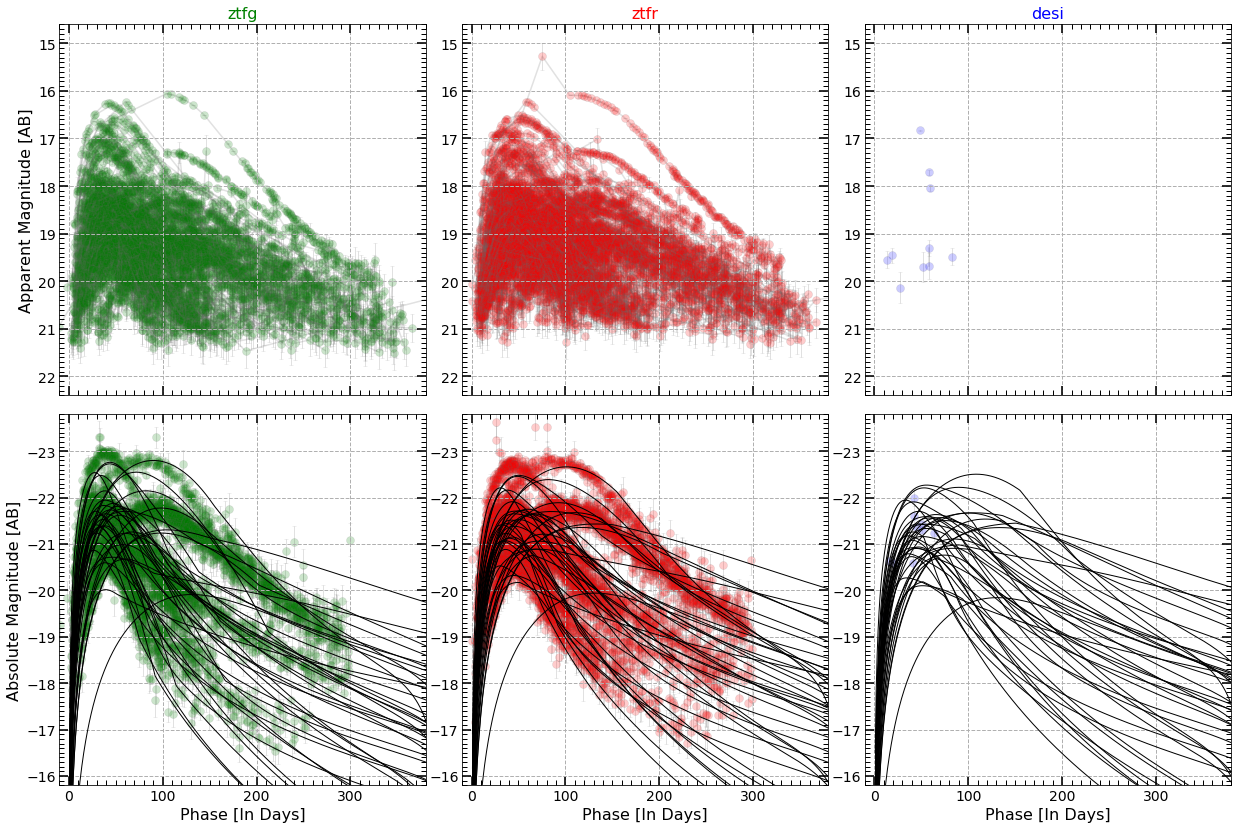

In [7]:
# ------------------------------------------------------------------------------------------------------------------- #
fig, ax = plt.subplots(2, 3, figsize=(21, 14), sharex=True)

lcs.stats['absmag_max'] = {}
for band in dict_bands.keys():
    lcs.stats['absmag_max'][band] = 99 * np.ones(len(data_mod['lcs']))

for lc in range(len(data_mod['lcs'])):
    lc_df = read_lc(lc)
#     if (data_mod['stats']['p_det'][lc] < 10) and (lc_df['absmag'].min() < -22.7):
    if data_mod['stats']['p_det'][lc] > -150:
        for band, df in lc_df.groupby('band'):
            plot_lcs(ax, df, lc, band, xlim=(-10, 380), alpha=0.2)

if runmodel == 'Template':
    ptf12 = pd.read_csv(file_template, sep='\s+', comment='#')
    distmag = z_to_distmod(0.107)
    
    ax[0][0].plot(ptf12['Phase'], ptf12['M_g'] + distmag, marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')
    ax[0][1].plot(ptf12['Phase'], ptf12['M_r'] + distmag, marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')
    ax[0][2].plot(ptf12['Phase'], ptf12['M_i'] + distmag, marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')
    ax[1][0].plot(ptf12['Phase'], ptf12['M_g'], marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')
    ax[1][1].plot(ptf12['Phase'], ptf12['M_r'], marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')
    ax[1][2].plot(ptf12['Phase'], ptf12['M_i'], marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')

elif runmodel == 'Magnetar':
    for idx in range(len(SLSN_prop['P'])):
        model = sncosmo.Model(source=source, effects=[dust], effect_names=['host'], effect_frames=['rest'])
        for (param, val) in SLSN_prop.items():
            model[param] = val[idx]
        phase_arr = np.arange(0, 400, 1)
        gmag = model.bandmag('ztfg', 'ab', phase_arr)
        rmag = model.bandmag('ztfr', 'ab', phase_arr)
        imag = model.bandmag('desi', 'ab', phase_arr)
        
        ax[1][0].plot(phase_arr, gmag, marker='', lw=1, ls='-', c='k', zorder=2, label='_nolegend_')
        ax[1][1].plot(phase_arr, rmag, marker='', lw=1, ls='-', c='k', zorder=2, label='_nolegend_')
        ax[1][2].plot(phase_arr, imag, marker='', lw=1, ls='-', c='k', zorder=2, label='_nolegend_')
else:
    print ('ERROR: Invalid Choice of Model')
    sys.exit(1)

ax[0][0].set_ylabel('Apparent Magnitude [AB]', fontsize=16)
ax[1][0].set_ylabel('Absolute Magnitude [AB]', fontsize=16)

fig.subplots_adjust(hspace=0.05, wspace=0.10)
fig.savefig('PLOT_LCS_{0}_{1}_{2}_{3}_{4}.pdf'.format(runmodel, zrange[0], zrange[1], rate, iteration),
            format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Single Simulated Light Curve [Specify Index]

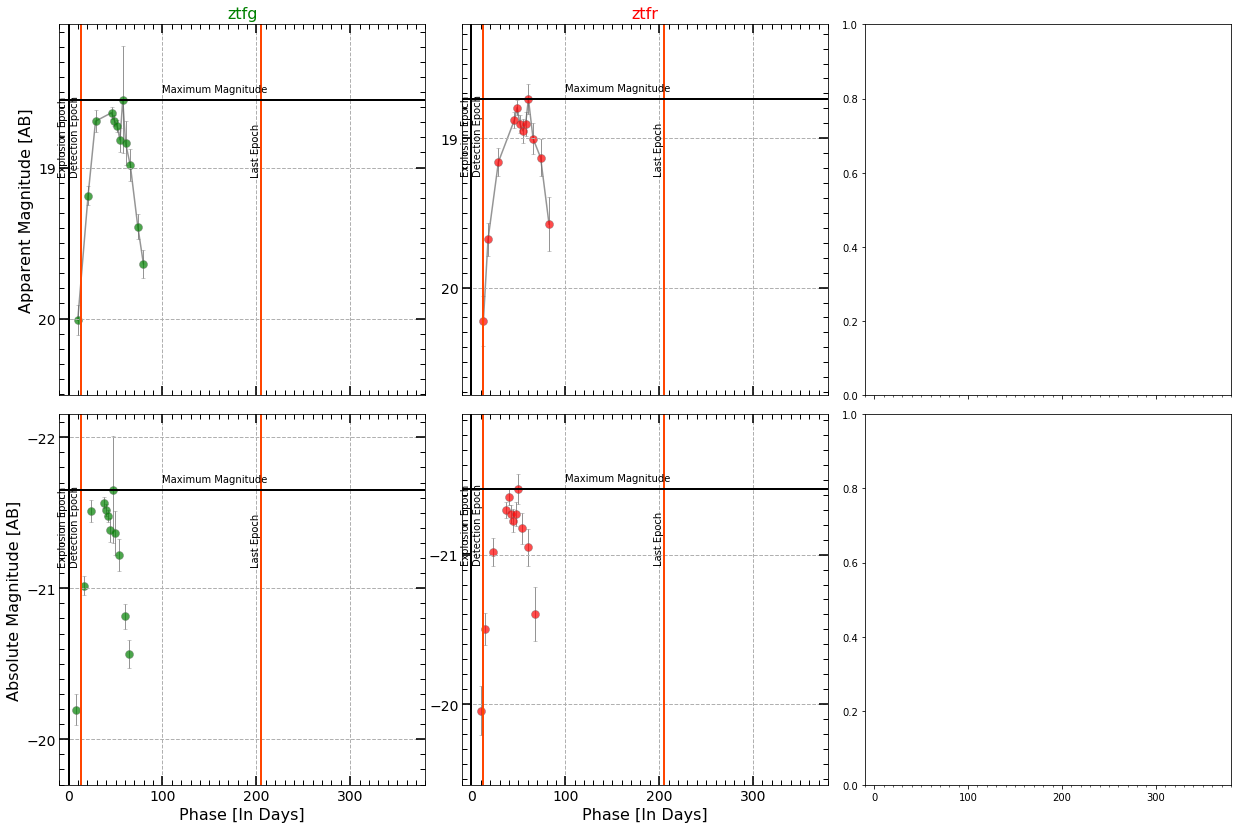

In [8]:
# ------------------------------------------------------------------------------------------------------------------- #
idx = 1
lc_df = read_lc(idx)

fig2, ax2 = plt.subplots(2, 3, figsize=(21, 14), sharex=True)

for band, df in lc_df.groupby('band'):
    plot_lcs(ax2, df, idx, band, xlim=(-10, 380), alpha=0.7, single=True)

# if runmodel == 'Template':
#     ptf12 = pd.read_csv(file_template, sep='\s+', comment='#')
#     distmag = z_to_distmod(0.107)
    
#     ax[0][0].plot(ptf12['Phase'], ptf12['M_g'] + distmag, marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')
#     ax[0][1].plot(ptf12['Phase'], ptf12['M_r'] + distmag, marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')
#     ax[0][2].plot(ptf12['Phase'], ptf12['M_i'] + distmag, marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')
#     ax[1][0].plot(ptf12['Phase'], ptf12['M_g'], marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')
#     ax[1][1].plot(ptf12['Phase'], ptf12['M_r'], marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')
#     ax[1][2].plot(ptf12['Phase'], ptf12['M_i'], marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')

# elif runmodel == 'Magnetar':
#     model = sncosmo.Model(source=source, effects=[dust], effect_names=['host'], effect_frames=['rest'])
#     for param in params_magnetar:
#         model[param] = data_mod['meta'][param][idx]
        
#     phase_arr = np.arange(0, 400, 1)
#     gmag = model.bandmag('ztfg', 'ab', phase_arr)
#     rmag = model.bandmag('ztfr', 'ab', phase_arr)
#     imag = model.bandmag('desi', 'ab', phase_arr)

#     ax2[1][0].plot(phase_arr, gmag, marker='', lw=1, ls='-', c='k', zorder=2, label='_nolegend_')
#     ax2[1][1].plot(phase_arr, rmag, marker='', lw=1, ls='-', c='k', zorder=2, label='_nolegend_')
#     ax2[1][2].plot(phase_arr, imag, marker='', lw=1, ls='-', c='k', zorder=2, label='_nolegend_')
# else:
#     print ('ERROR: Invalid Choice of Model')
#     sys.exit(1)

ax2[0][0].set_ylabel('Apparent Magnitude [AB]', fontsize=16)
ax2[1][0].set_ylabel('Absolute Magnitude [AB]', fontsize=16)

fig2.subplots_adjust(hspace=0.05, wspace=0.10)
fig2.savefig('PLOT_LC-{0}_{1}_{2}_{3}_{4}_{5}.pdf'.format(idx, runmodel, zrange[0], zrange[1], rate, iteration), format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig2)
# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Detection Phase Distribution of Simulated Light Curves

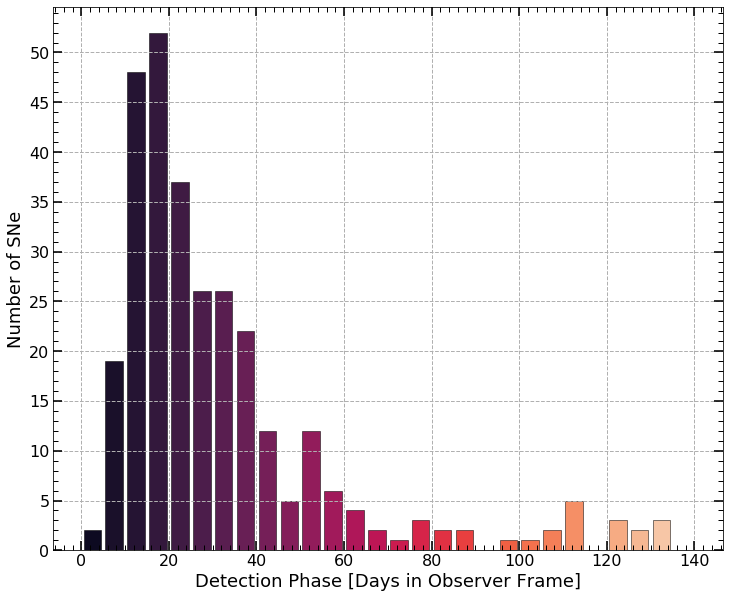

In [22]:
# ------------------------------------------------------------------------------------------------------------------- #
fig3 = plt.figure(figsize=(12, 10))
ax3 = fig3.add_subplot(111)

heights, bins = np.histogram(lcs.stats['p_det'], range=(0, 140), bins=28)
# heights, bins = np.histogram(lcs.stats['p_det'], range=(-90, 60), bins=30)
centers = (bins[:-1] + bins[1:]) / 2

ax3.bar(centers, heights, width=4, ec='k', lw=0.5, color=sns.color_palette('rocket', len(bins)))
# ax3.hist(lcs.stats['p_det'], histtype='bar', rwidth=0.75, color='dimgrey', range=(-10, 120), bins=32)

# ax3.set_xlim(-120, 310)
set_plotparams(ax3, xticks=(20, 2), yticks=(5, 1), fs=16)

ax3.set_xlabel('Detection Phase [Days in Observer Frame]', fontsize=18)
ax3.set_ylabel('Number of SNe', fontsize=18)

fig3.savefig('PLOT_DPD_{0}_{1}_{2}_{3}_{4}.pdf'.format(runmodel, zrange[0], zrange[1], rate, iteration),
             format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig3)
# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Redshift Distribution of Simulated Light Curves

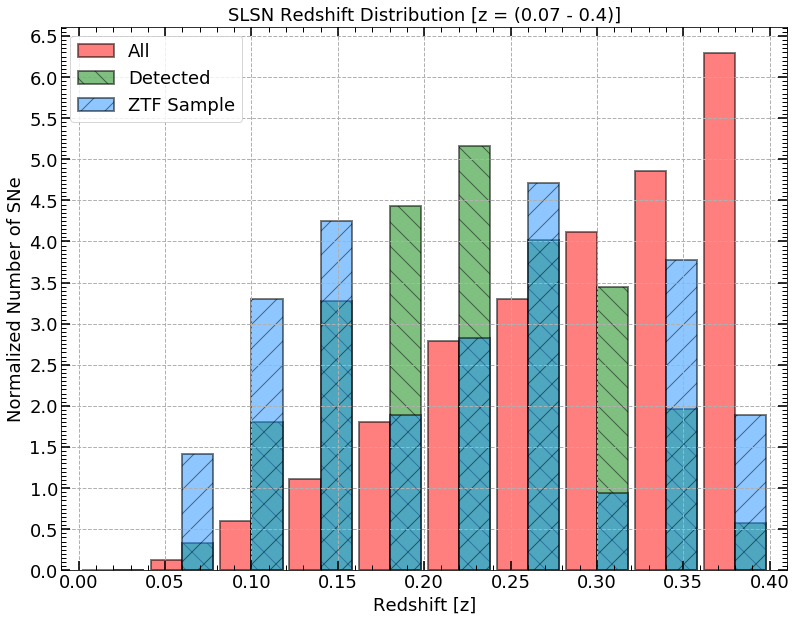

In [40]:
# ------------------------------------------------------------------------------------------------------------------- #
fig4 = plt.figure(figsize=(13, 10))
ax4 = fig4.add_subplot(111)

zh_full, zb_full = np.histogram(lcs.meta_full['z'], range=(0, 0.4), normed=True, bins=10)
zh, zb = np.histogram(lcs.meta['z'], range=(0, 0.4), normed=True, bins=10)
zh_ztf, zb_ztf = np.histogram(ztfz, range=(0, 0.4), normed=True, bins=10)
zc_full = (zb_full[:-1] + zb_full[1:]) / 2
zc = (zb[:-1] + zb[1:]) / 2
zc_ztf = (zb_ztf[:-1] + zb_ztf[1:]) / 2

ax4.bar(zc_full - 0.009, zh_full, width=0.018, alpha=0.5, ec='k', lw=2, color='red', label='All')
ax4.bar(zc + 0.009, zh, width=0.018, alpha=0.5, ec='k', lw=2, color='green', hatch='\ ', label='Detected')
ax4.bar(zc_ztf + 0.009, zh_ztf, width=0.018, alpha=0.5, ec='k', lw=2, color='dodgerblue',
        hatch='/', label='ZTF Sample')

# ax4.hist(lcs.meta_full['z'], lw=2, ls='-', histtype='step', color='orangered', range=(0,0.05), bins=25, label='All')
# ax4.hist(lcs.meta['z'], lw=2, ls='-', histtype='step', color='navy', range=(0, 0.05), bins=25, label='Detected')

# ax4.set_ylim(0, 335)
ax4.set_xlim(-0.01, 0.41)
# ax4.axvline(zrange[0], ls='-', lw=2, c='k')
# ax4.axvline(zrange[1], ls='-', lw=2, c='k')
# ax4.text((zrange[0] + zrange[1]) / 2.5, 0.9 * ax4.get_ylim()[1], s='Simulation Regime', color='k', fontsize=18)
# ax4.fill_betweenx(ax4.get_ylim(), zrange[0], zrange[1], color='tomato', alpha=0.15)

ax4.legend(fontsize=18, loc=2)
# set_plotparams(ax4, xticks=(0.05, 0.01), yticks=(50, 5), fs=18)
set_plotparams(ax4, xticks=(0.05, 0.01), yticks=(0.5, 0.05), fs=18)

ax4.set_xlabel('Redshift [z]', fontsize=18)
ax4.set_ylabel('Normalized Number of SNe', fontsize=18)
ax4.set_title('SLSN Redshift Distribution [z = ({0} - {1})]'.format(zrange[0], zrange[1]), fontsize=18)

# axins = ax4.inset_axes([0.08, 0.47, 0.53, 0.55])
# # ax4.indicate_inset_zoom(axins)

# # axins.bar(zcentersfull - 0.005, zhsfull, width=0.01, alpha=0.9, color='orangered', label='All')
# axins.bar(zcenters + 0.005, zhs, width=0.01, alpha=0.9, ec='k', lw=0.8, color='navy', label='Detected')

# axins.set_xlim(-0.02, 0.45)
# axins.set_ylim(0, 110)
# set_plotparams(axins, xticks=(0.1, 0.01), yticks=(20, 2), fs=16)

fig4.savefig('PLOT_RD_{0}_{1}_{2}_{3}_{4}.pdf'.format(runmodel, zrange[0], zrange[1], rate, iteration),
             format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig4)
# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Peak Apparent Magnitude Distribution of Simulated Light Curves

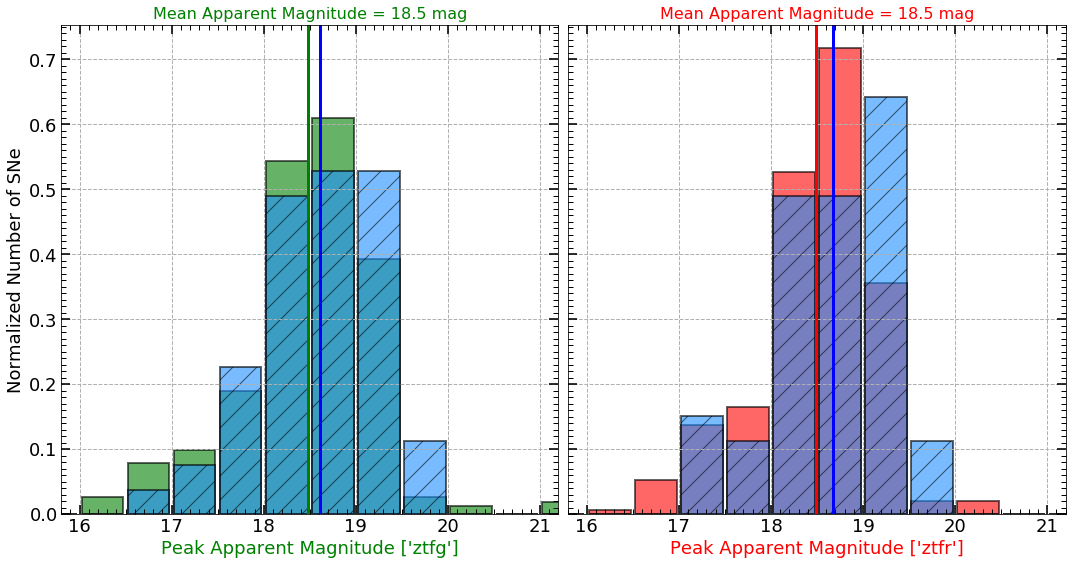

In [24]:
# ------------------------------------------------------------------------------------------------------------------- #
fig5, (ax51, ax52) = plt.subplots(1, 2, sharey=True, figsize=(18, 9))

h_g, b_g = np.histogram(lcs.stats['mag_max']['ztfg'], range=(15.5, 21.5), normed=True, bins=12)
h_r, b_r = np.histogram(lcs.stats['mag_max']['ztfr'], range=(15.5, 21.5), normed=True, bins=12)
happ_g, bapp_g = np.histogram(ztfappg, range=(15.5, 21.5), normed=True, bins=12)
happ_r, bapp_r = np.histogram(ztfappr, range=(15.5, 21.5), normed=True, bins=12)
c_g = (b_g[:-1] + b_g[1:]) / 2
c_r = (b_r[:-1] + b_r[1:]) / 2
capp_g = (bapp_g[:-1] + bapp_g[1:]) / 2
capp_r = (bapp_r[:-1] + bapp_r[1:]) / 2

# ax51.bar(c_g, h_g, width=0.4, ec='k', lw=0.5, color=sns.color_palette('rocket', len(b_g)))
# ax52.bar(c_r, h_r, width=0.4, ec='k', lw=0.5, color=sns.color_palette('rocket', len(b_r)))
ax51.bar(c_g, h_g, width=0.45, ec='k', lw=2, alpha=0.6, color='green')
ax52.bar(c_r, h_r, width=0.45, ec='k', lw=2, alpha=0.6, color='red')
ax51.bar(capp_g, happ_g, width=0.45, ec='k', lw=2, alpha=0.6, hatch='/', color='dodgerblue')
ax52.bar(capp_r, happ_r, width=0.45, ec='k', lw=2, alpha=0.6, hatch='/', color='dodgerblue')

xarr = np.arange(15.5, 21.5, 0.1)
mean_g = np.average(c_g, weights=h_g)
mean_r = np.average(c_r, weights=h_r)
std_g = np.sqrt(np.average((c_g - mean_g) ** 2, weights=h_g))
std_r = np.sqrt(np.average((c_r - mean_r) ** 2, weights=h_r))

meanapp_g = np.average(capp_g, weights=happ_g)
meanapp_r = np.average(capp_r, weights=happ_r)
stdapp_g = np.sqrt(np.average((capp_g - meanapp_g) ** 2, weights=happ_g))
stdapp_r = np.sqrt(np.average((capp_r - meanapp_r) ** 2, weights=happ_r))

# import scipy.stats as stats
# gauss_g = stats.norm.pdf(xarr, mean_g, std_g)
# gauss_r = stats.norm.pdf(xarr, mean_r, std_r)
# ax51.fill_between(xarr, gauss_g * np.sum(h_g), color='g')
# ax52.fill_between(xarr, gauss_r * np.sum(h_r), color='r')

ax51.set_xlim(15.8, 21.2)
ax52.set_xlim(15.8, 21.2)
ax51.axvline(mean_g, ls='-', lw=3, color='g')
ax52.axvline(mean_r, ls='-', lw=3, color='r')
ax51.axvline(meanapp_g, ls='-', lw=3, color='blue')
ax52.axvline(meanapp_r, ls='-', lw=3, color='blue')
ax51.set_title('Mean Apparent Magnitude = {0:.1f} mag'.format(mean_g), color='g', fontsize=16)
ax52.set_title('Mean Apparent Magnitude = {0:.1f} mag'.format(mean_r), color='r', fontsize=16)

# ax51.axvline(mean_g - 3 * std_g, ls='-', lw=1, color='g')
# ax51.axvline(mean_g + 3 * std_g, ls='-', lw=1, color='g')
# ax52.axvline(mean_r - 3 * std_r, ls='-', lw=1, color='r')
# ax52.axvline(mean_r + 3 * std_r, ls='-', lw=1, color='r')

set_plotparams(ax51, xticks=(1, 0.1), yticks=(0.1, 0.01), fs=18)
set_plotparams(ax52, xticks=(1, 0.1), yticks=(0.1, 0.01), fs=18)
ax51.set_xlabel("Peak Apparent Magnitude ['ztfg']", color='g', fontsize=18)
ax52.set_xlabel("Peak Apparent Magnitude ['ztfr']", color='r', fontsize=18)
ax51.set_ylabel("Normalized Number of SNe", fontsize=18)

fig5.subplots_adjust(wspace=0.02)
fig5.savefig('PLOT_AppMD_{0}_{1}_{2}_{3}_{4}.pdf'.format(runmodel, zrange[0], zrange[1], rate, iteration),
             format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig5)
# ------------------------------------------------------------------------------------------------------------------- #


### PLOT - Peak Absolute Magnitude Distribution of Simulated Light Curves

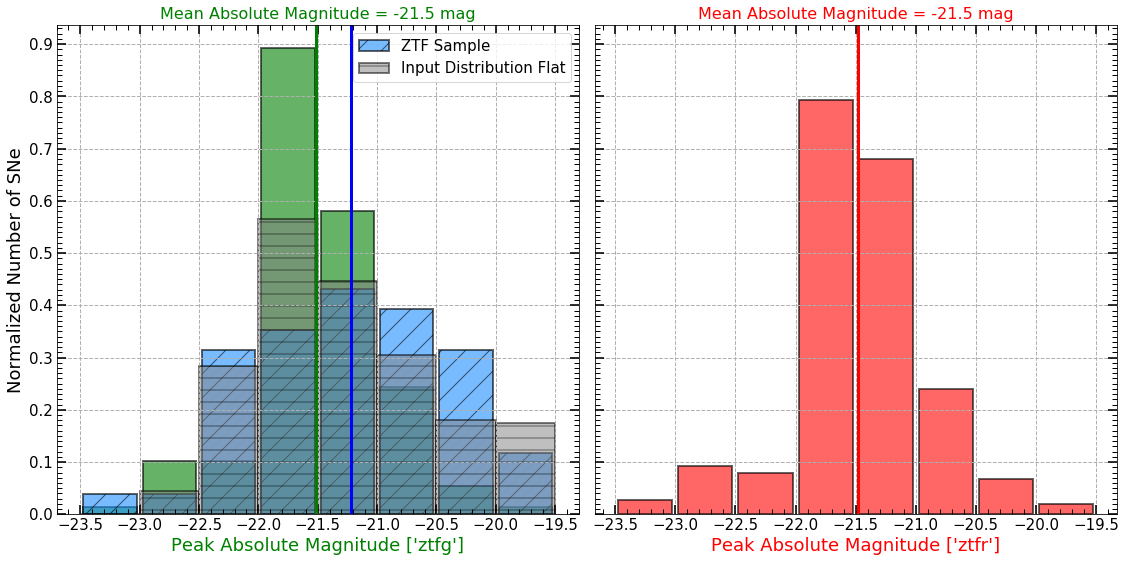

In [35]:
# ------------------------------------------------------------------------------------------------------------------- #
fig5, (ax51, ax52) = plt.subplots(1, 2, sharey=True, figsize=(19, 9))

h_g, b_g = np.histogram(lcs.stats['absmag_max']['ztfg'], range=(-23.5, -19.5), normed=True, bins=8)
h_r, b_r = np.histogram(lcs.stats['absmag_max']['ztfr'], range=(-23.5, -19.5), normed=True, bins=8)
habs_g, babs_g = np.histogram(ztfsample, range=(-23.5, -19.5), normed=True, bins=8)
c_g = (b_g[:-1] + b_g[1:]) / 2
c_r = (b_r[:-1] + b_r[1:]) / 2
cabs_g = (babs_g[:-1] + babs_g[1:]) / 2

# ax51.bar(c_g, h_g, width=0.4, ec='k', lw=0.5, color=sns.color_palette('rocket', len(b_g)))
# ax52.bar(c_r, h_r, width=0.4, ec='k', lw=0.5, color=sns.color_palette('rocket', len(b_r)))
ax51.bar(c_g, h_g, width=0.45, ec='k', lw=2, alpha=0.6, color='green')
ax52.bar(c_r, h_r, width=0.45, ec='k', lw=2, alpha=0.6, color='red')
ax51.bar(cabs_g, habs_g, width=0.45, color='dodgerblue', ec='k', alpha=0.6, lw=2, hatch='/', label='ZTF Sample')
ax51.bar(c_iterf, h_iterf, width=0.5, color='grey', ec='k', alpha=0.5, lw=2,
         hatch='-',label='Input Distribution Flat')

xarr = np.arange(-23.5, -19.5, 0.1)
mean_g = np.average(c_g, weights=h_g)
mean_r = np.average(c_r, weights=h_r)
std_g = np.sqrt(np.average((c_g - mean_g) ** 2, weights=h_g))
std_r = np.sqrt(np.average((c_r - mean_r) ** 2, weights=h_r))

meanabs_g = np.average(cabs_g, weights=habs_g)
# meanabs_r = np.average(cabs_r, weights=habs_r)
stdabs_g = np.sqrt(np.average((cabs_g - meanabs_g) ** 2, weights=habs_g))
# stdabs_r = np.sqrt(np.average((cabs_r - meanabs_r) ** 2, weights=habs_r))

# import scipy.stats as stats
# gauss_g = stats.norm.pdf(xarr, mean_g, std_g)
# gauss_r = stats.norm.pdf(xarr, mean_r, std_r)
# ax51.fill_between(xarr, gauss_g * np.sum(h_g), color='g')
# ax52.fill_between(xarr, gauss_r * np.sum(h_r), color='r')

ax51.legend(fontsize=15)
ax51.axvline(mean_g, ls='-', lw=3, color='g')
ax52.axvline(mean_r, ls='-', lw=3, color='r')
ax51.axvline(meanabs_g, ls='-', lw=3, color='blue')
# ax52.axvline(meanabs_r, ls='-', lw=3, color='g')
ax51.set_title('Mean Absolute Magnitude = {0:.1f} mag'.format(mean_g), color='g', fontsize=16)
ax52.set_title('Mean Absolute Magnitude = {0:.1f} mag'.format(mean_r), color='r', fontsize=16)

# ax51.axvline(mean_g - 3 * std_g, ls='-', lw=1, color='g')
# ax51.axvline(mean_g + 3 * std_g, ls='-', lw=1, color='g')
# ax52.axvline(mean_r - 3 * std_r, ls='-', lw=1, color='r')
# ax52.axvline(mean_r + 3 * std_r, ls='-', lw=1, color='r')

set_plotparams(ax51, xticks=(0.5, 0.1), yticks=(0.1, 0.01), fs=15)
set_plotparams(ax52, xticks=(0.5, 0.1), yticks=(0.1, 0.01), fs=15)
ax51.set_xlabel("Peak Absolute Magnitude ['ztfg']", color='g', fontsize=18)
ax52.set_xlabel("Peak Absolute Magnitude ['ztfr']", color='r', fontsize=18)
ax51.set_ylabel("Normalized Number of SNe", fontsize=18)

fig5.subplots_adjust(wspace=0.03)
fig5.savefig('PLOT_AbsMD_{0}_{1}_{2}_{3}_{4}.pdf'.format(runmodel, zrange[0], zrange[1], rate, iteration),
             format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig5)
# ------------------------------------------------------------------------------------------------------------------- #


### Compute Peak Abs Mag and Rise Time of Models from Nicholl et al. (2017)

In [13]:
# ------------------------------------------------------------------------------------------------------------------- #
dict_peakabsmag = {'ztfg': [], 'ztfr': [], 'desi': []}
dict_risetime = {'ztfg': [], 'ztfr': [], 'desi': []}

for idx in range(len(SLSN_prop['P'])):
    model = sncosmo.Model(source=source, effects=[dust], effect_names=['host'], effect_frames=['rest'])
    for (param, val) in SLSN_prop.items():
        model[param] = val[idx]

    phase_arr = np.arange(1, 200, 0.5)
    gmag = model.bandmag('ztfg', 'ab', phase_arr)
    rmag = model.bandmag('ztfr', 'ab', phase_arr)
    imag = model.bandmag('desi', 'ab', phase_arr)
    
    gmax = gmag.min()
    rmax = rmag.min()
    imax = imag.min()
    
    grise = phase_arr[np.where(gmag == gmax)]
    rrise = phase_arr[np.where(rmag == rmax)]
    irise = phase_arr[np.where(imag == imax)]

    dict_peakabsmag['ztfg'].append(gmax)
    dict_peakabsmag['ztfr'].append(rmax)
    dict_peakabsmag['desi'].append(imax)

    dict_risetime['ztfg'].append(grise[0])
    dict_risetime['ztfr'].append(rrise[0])
    dict_risetime['desi'].append(irise[0])
    
# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Rise Time Distribution of the Magnetar Model

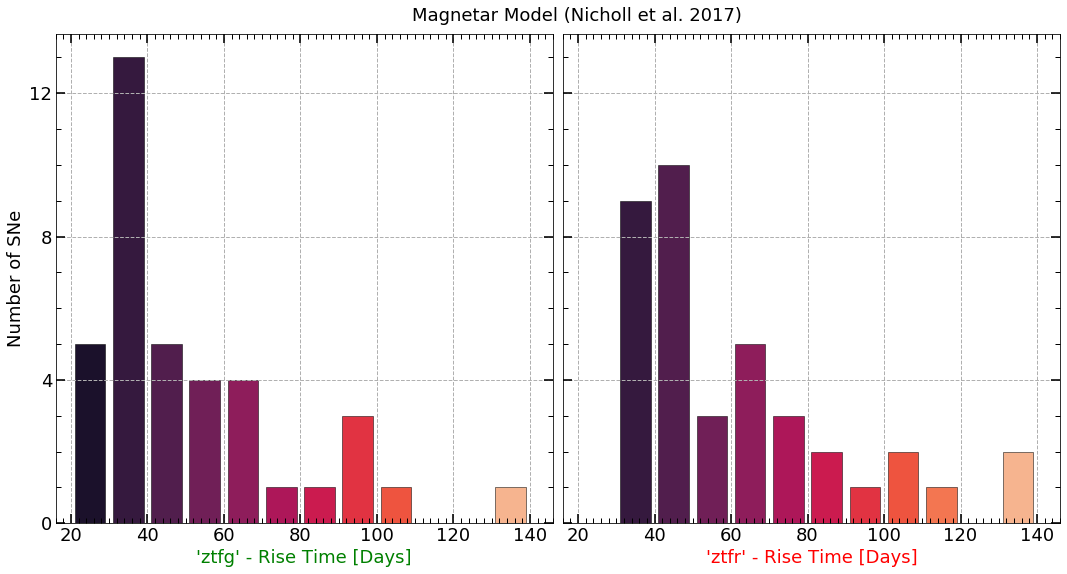

In [26]:
# ------------------------------------------------------------------------------------------------------------------- #
fig6, (ax61, ax62) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(18, 9))

rh_g, rbins_g = np.histogram(dict_risetime['ztfg'], range=(20, 140), bins=12)
rh_r, rbins_r = np.histogram(dict_risetime['ztfr'], range=(20, 140), bins=12)
rcen_g = (rbins_g[:-1] + rbins_g[1:]) / 2
rcen_r = (rbins_r[:-1] + rbins_r[1:]) / 2

ax61.bar(rcen_g, rh_g, width=8, ec='k', lw=0.5, color=sns.color_palette('rocket', int(len(rbins_g))))
ax62.bar(rcen_r, rh_r, width=8, ec='k', lw=0.5, color=sns.color_palette('rocket', int(len(rbins_r))))

ax61.set_xlim(16, 146)
set_plotparams(ax61, xticks=(20, 2), yticks=(4, 1), fs=18)
set_plotparams(ax62, xticks=(20, 2), yticks=(4, 1), fs=18)
ax61.set_xlabel("'ztfg' - Rise Time [Days]", color='g', fontsize=18)
ax62.set_xlabel("'ztfr' - Rise Time [Days]", color='r', fontsize=18)
ax61.set_ylabel('Number of SNe', fontsize=18)

fig6.text(0.4, 0.9, 'Magnetar Model (Nicholl et al. 2017)', fontsize=18)
fig6.subplots_adjust(wspace=0.02)
fig6.savefig('PLOT_MagnetarModelRiseTimeDistribution.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig6)
# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Peak Absolute Magnitude Distribution of the Magnetar Model

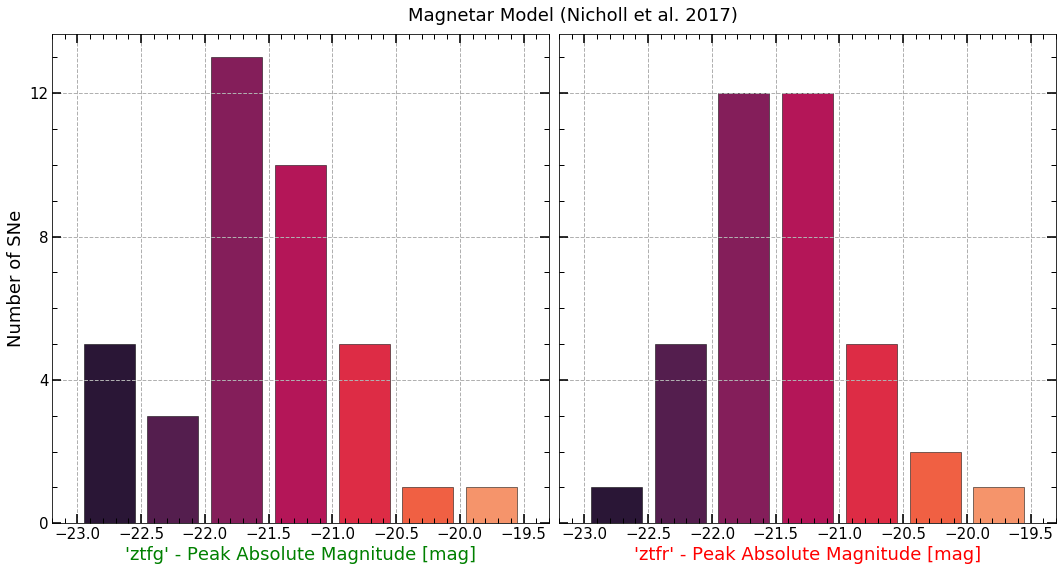

In [27]:
# ------------------------------------------------------------------------------------------------------------------- #
fig7, (ax71, ax72) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(18, 9))

mh_g, mbins_g = np.histogram(dict_peakabsmag['ztfg'], range=(-23.0, -19.5), bins=7)
mh_r, mbins_r = np.histogram(dict_peakabsmag['ztfr'], range=(-23.0, -19.5), bins=7)
mcen_g = (mbins_g[:-1] + mbins_g[1:]) / 2
mcen_r = (mbins_r[:-1] + mbins_r[1:]) / 2

ax71.bar(mcen_g, mh_g, width=0.4, ec='k', lw=0.5, color=sns.color_palette('rocket', int(len(mbins_g))))
ax72.bar(mcen_r, mh_r, width=0.4, ec='k', lw=0.5, color=sns.color_palette('rocket', int(len(mbins_r))))

ax71.set_xlim(-23.2, -19.3)
set_plotparams(ax71, xticks=(0.5, 0.1), yticks=(4, 1), fs=15)
set_plotparams(ax72, xticks=(0.5, 0.1), yticks=(4, 1), fs=15)
ax71.set_xlabel("'ztfg' - Peak Absolute Magnitude [mag]", color='g', fontsize=18)
ax72.set_xlabel("'ztfr' - Peak Absolute Magnitude [mag]", color='r', fontsize=18)
ax71.set_ylabel('Number of SNe', fontsize=18)

fig7.text(0.4, 0.9, 'Magnetar Model (Nicholl et al. 2017)', fontsize=18)
fig7.subplots_adjust(wspace=0.02)
fig7.savefig('PLOT_MagnetarModelPeakAbsMagDistribution.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig7)
# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Detectability Variation with Peak Magnitude of the Template Light Curve

In [16]:
# # ------------------------------------------------------------------------------------------------------------------- #
# data_df = pd.read_csv(os.path.join(DIR_OUTPUT, 'Run_Feb6_MagWidthMaster/LogSim_ZTF.dat'), sep='\s+', comment='#')
# data_df['Ratio'] = data_df['FilteredLCs'] / data_df['RawLCs']
# temp1_df = data_df[data_df['RiseTime'] == 70]
# temp2_df = data_df[data_df['PeakAbsMag'] == -21.642]

# fig8 = plt.figure(figsize=(10, 8))
# ax8 = fig8.add_subplot(111)

# ax8.plot(temp1_df['PeakAbsMag'], temp1_df['FilteredLCs'], ls='', mfc='navy', c='b', marker='*', ms=30, label='_nolegend_')
# set_plotparams(ax8, xticks=(0.5, 0.1), yticks=(200, 20), fs=16, color='navy')
# ax8.set_xlabel("'ztfr' - Peak Absolute Magnitude [mag]", fontsize=18)
# ax8.set_ylabel("Filtered SLSNe", color='navy', fontsize=18)
# ax8.set_title("z = ({0}, {1}), Rate = {2}".format(zrange[0], zrange[1], rate * 100) + r"$\rm\ Gpc^{-3}\ yr^{-1}$",
#               fontsize=18)

# ax8y = ax8.twinx()
# ax8y.yaxis.set_major_locator(MultipleLocator(0.1))
# ax8y.yaxis.set_minor_locator(MultipleLocator(0.01))
# ax8.tick_params(axis='x', which='major', direction='in', width=1.6, length=9, color='k', labelcolor='k', labelsize=16)
# ax8.tick_params(axis='x', which='minor', direction='in', width=1.0, length=5, color='k', labelcolor='k', labelsize=16)
# ax8y.tick_params(axis='y', which='major', direction='in', width=1.6, length=9, color='r', labelcolor='r', labelsize=16)
# ax8y.tick_params(axis='y', which='minor', direction='in', width=1.0, length=5, color='r', labelcolor='r', labelsize=16)
# ax8y.set_ylabel('Filtered Ratio', color='orangered', fontsize=18)

# ax8y.plot(temp1_df['PeakAbsMag'], temp1_df['Ratio'], color='r', mfc='orangered', ls='', marker='o', ms=20)
# fig8.savefig('PLOT_PeakAbsMagDetectabilityVariation_{0}_{1}_{2}.pdf'.format(zrange[0], zrange[1], rate),
#              format='pdf', dpi=2000, bbox_inches='tight')
# plt.show()
# plt.close(fig8)
# # ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Detectability Variation with Rise Time of the Template Light Curve

In [17]:
# # ------------------------------------------------------------------------------------------------------------------- #
# fig9 = plt.figure(figsize=(10, 8))
# ax9 = fig9.add_subplot(111)

# ax9.plot(temp2_df['RiseTime'], temp2_df['FilteredLCs'], ls='', mfc='navy', c='orangered', 
#          marker='*', ms=30, label='_nolegend_')
# set_plotparams(ax9, xticks=(20, 2), yticks=(100, 10), fs=18)
# ax9.set_xlabel("'ztfr' - RiseTime [Days]", fontsize=18)
# ax9.set_ylabel("Filtered SLSNe", fontsize=18)
# ax9.set_title("z = ({0}, {1}), Rate = {2}".format(zrange[0], zrange[1], rate * 100) + r"$\rm\ Gpc^{-3}\ yr^{-1}$",
#               fontsize=18)

# ax9y = ax9.twinx()
# ax9y.yaxis.set_major_locator(MultipleLocator(0.01))
# ax9y.yaxis.set_minor_locator(MultipleLocator(0.001))
# ax9.tick_params(axis='x', which='major', direction='in', width=1.6, length=9, color='k', labelcolor='k', labelsize=16)
# ax9.tick_params(axis='x', which='minor', direction='in', width=1.0, length=5, color='k', labelcolor='k', labelsize=16)
# ax9y.tick_params(axis='y', which='major', direction='in', width=1.6, length=9, color='r', labelcolor='r', labelsize=16)
# ax9y.tick_params(axis='y', which='minor', direction='in', width=1.0, length=5, color='r', labelcolor='r', labelsize=16)
# ax9y.set_ylabel('Filtered Ratio', color='orangered', fontsize=18)
# ax9y.plot(temp2_df['RiseTime'], temp2_df['Ratio'], color='b', mfc='dodgerblue', ls='', marker='o', ms=20)

# fig9.savefig('PLOT_RiseTimeDetectabilityVariation_{0}_{1}_{2}.pdf'.format(zrange[0], zrange[1], rate),
#              format='pdf', dpi=2000, bbox_inches='tight')
# plt.show()
# plt.close(fig9)
# # ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Filtered Detection Distribution of Simulated Light Curves wrt Rates

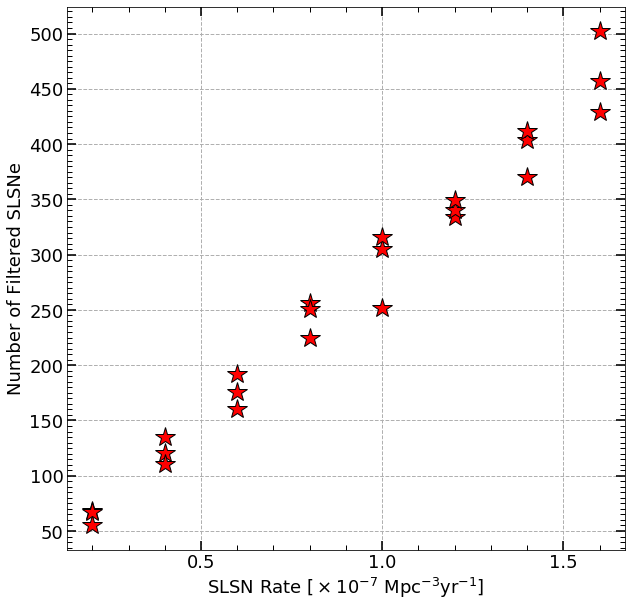

In [18]:
# ------------------------------------------------------------------------------------------------------------------- #
fig6 = plt.figure(figsize=(10, 10))
ax6 = fig6.add_subplot(111)

data_df = pd.read_csv(os.path.join(DIR_OUTPUT, 'LogSim_ZTF.dat'), sep='\s+', comment='#')

ax6.plot(data_df['Rate'], data_df['FilteredLCs'], ls='', mfc='r', c='k', marker='*', ms=20, label='_nolegend_')

set_plotparams(ax6, xticks=(0.5, 0.1), yticks=(50, 5), fs=18)
ax6.set_xlabel(r"SLSN Rate [$\rm \times 10^{-7}\ Mpc^{-3} yr^{-1}$]", fontsize=18)
ax6.set_ylabel('Number of Filtered SLSNe', fontsize=18)

fig6.savefig('PLOT_FilteredDetectionDistribution_{0}_{1}_{2}.pdf'.format(runmodel, zrange[0], zrange[1]),
             format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig6)
# ------------------------------------------------------------------------------------------------------------------- #

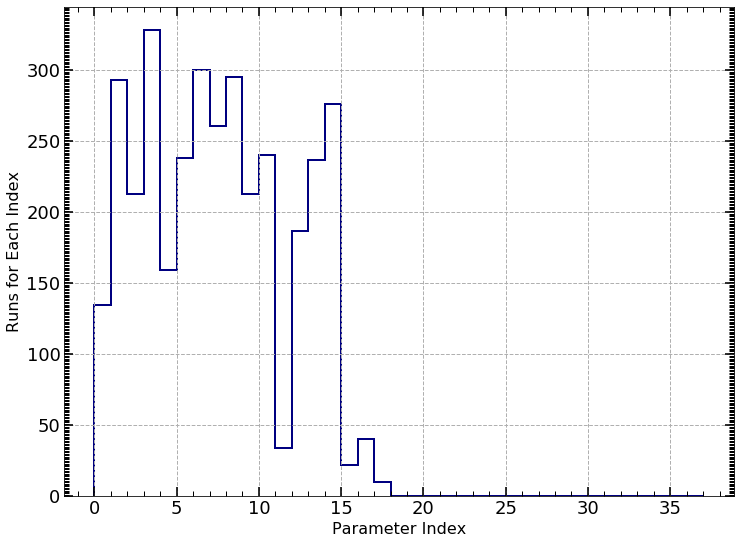

In [43]:
data = pd.read_csv(os.path.join(DIR_HOME, 'notebooks/LogSim_Indexes.dat'), sep='\s+', names=['run', 'idx'])
# print (data)
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)

# ax.plot(data['idx'], data['run'])
ax.hist(data['idx'], lw=2, ls='-', histtype='step', color='navy', range=(0, 37), bins=37, label='Detected')
set_plotparams(ax, xticks=(5, 1), yticks=(50, 1), fs=18)

ax.set_ylabel('Runs for Each Index', fontsize=16)
ax.set_xlabel('Parameter Index', fontsize=16)

plt.show()
plt.close(fig)